In [4]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [5]:
api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ["2024-05-05-18-02-19", "2024-05-05-23-35-37"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs


<Runs ajzero/AlphaZero>

In [6]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
# df = df[df['Evaluation/Mean_Returns'] != 0]

ncols, nrows = df["ncols"][0], 8
df

100%|██████████| 120/120 [00:00<00:00, 132.25it/s]


,episodes,environment_steps,Evaluation/Timesteps,Training/Value_Simularities,Self_Play/Min_Timesteps,Self_Play/EMA_Discounted_Return,Self_Play/Mean_Discounted_Return,Self_Play/Mean_Timesteps,Self_Play/Mean_Return,Training/Policy_loss,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,180,6143,"{'bins': [99.5, 99.515625, 99.53125, 99.546875...",0.738104,19,0.307343,0.303790,24.666667,1.000000,0.905693,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
1,180,17924,"{'_type': 'histogram', 'bins': [99.5, 99.51562...",0.555015,37,0.007991,0.026297,89.500000,0.166667,1.272716,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
2,180,17572,"{'_type': 'histogram', 'bins': [99.5, 99.51562...",0.431829,27,-0.013227,-0.043920,87.833333,-0.166667,1.255070,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
3,180,14710,"{'bins': [13.5, 13.515625, 13.53125, 13.546875...",0.721602,17,0.251662,0.361213,21.000000,1.000000,1.133873,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
4,180,10966,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.517542,27,0.148627,0.144094,41.333333,1.000000,1.152863,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,180,16497,"{'_type': 'histogram', 'bins': [99.5, 99.51562...",0.647451,30,-0.028788,-0.037656,88.333333,-0.166667,1.314253,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
116,180,18000,"{'_type': 'histogram', 'bins': [99.5, 99.51562...",0.248147,100,0.000000,0.000000,100.000000,0.000000,1.282355,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
117,180,11905,"{'bins': [13.5, 13.515625, 13.53125, 13.546875...",0.468331,21,0.218246,0.255939,30.666667,1.000000,1.247722,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
118,180,7485,"{'bins': [99.5, 99.515625, 99.53125, 99.546875...",0.779069,22,0.257052,0.253832,28.500000,1.000000,1.077270,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity


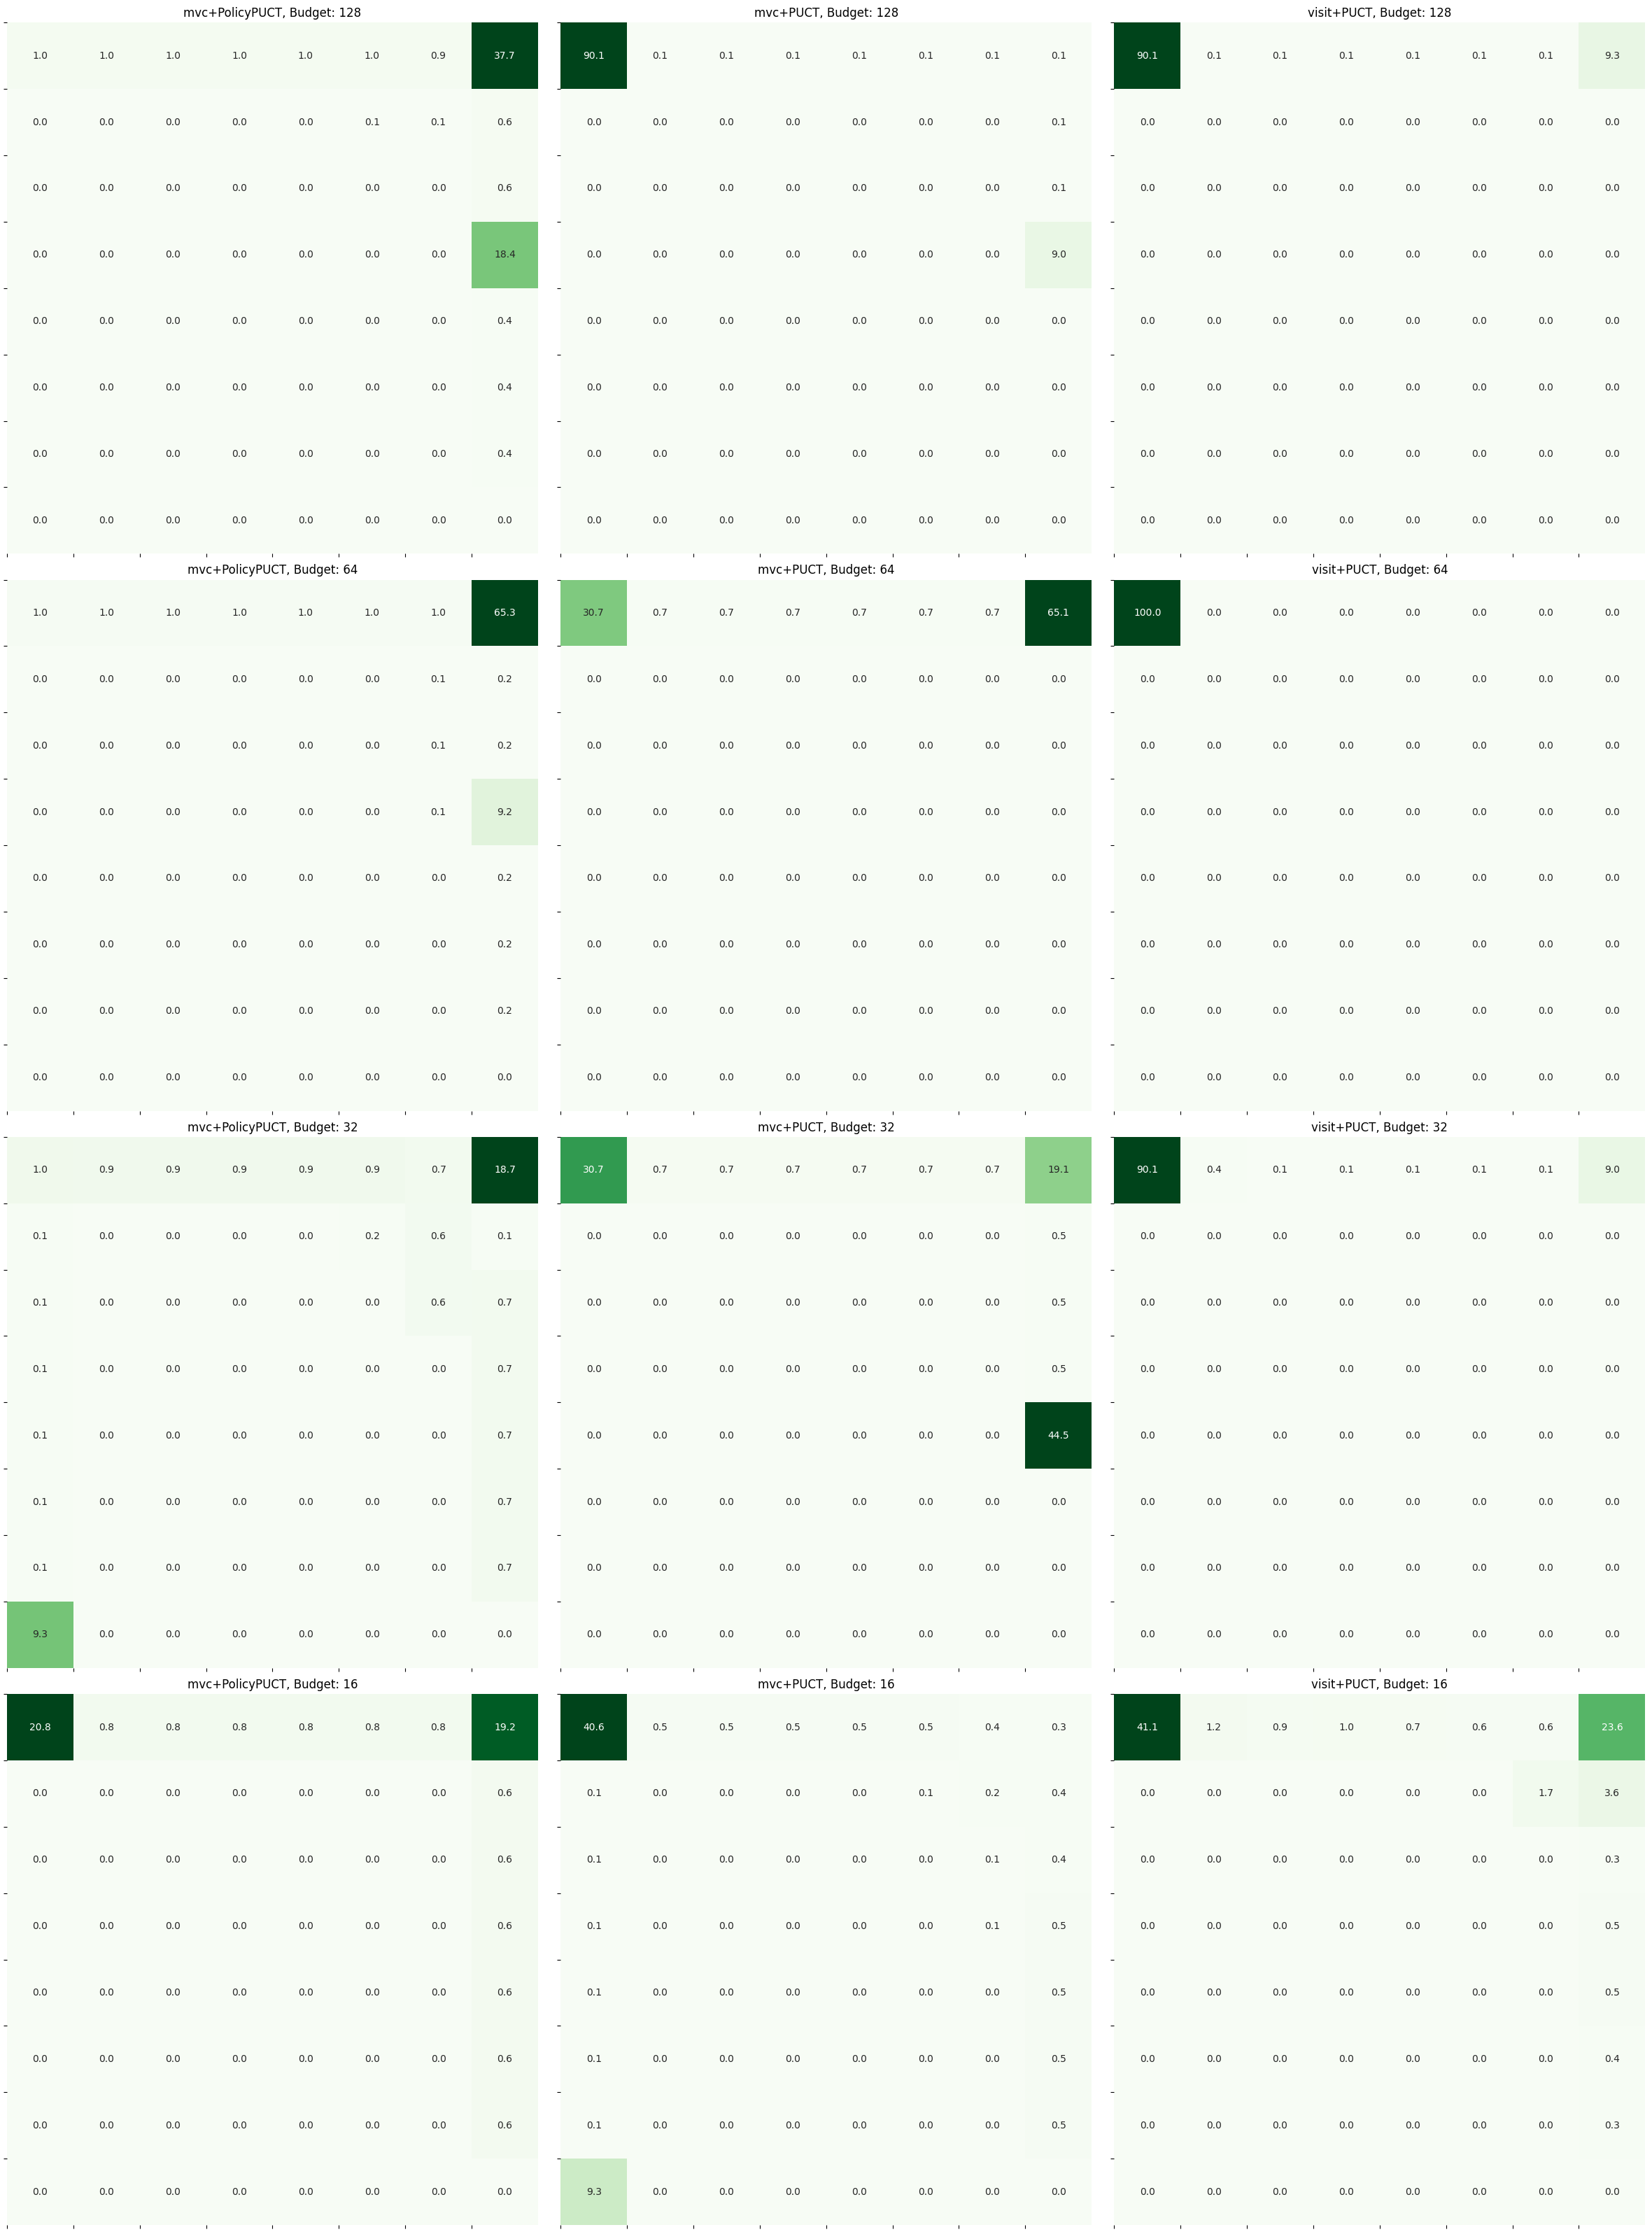

In [9]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['Evaluation/Trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()

# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs[max(i, j)]
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.1f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")



plt.tight_layout()
plt.savefig("outfiles/8x8lake_training_dist.pdf")
plt.show()


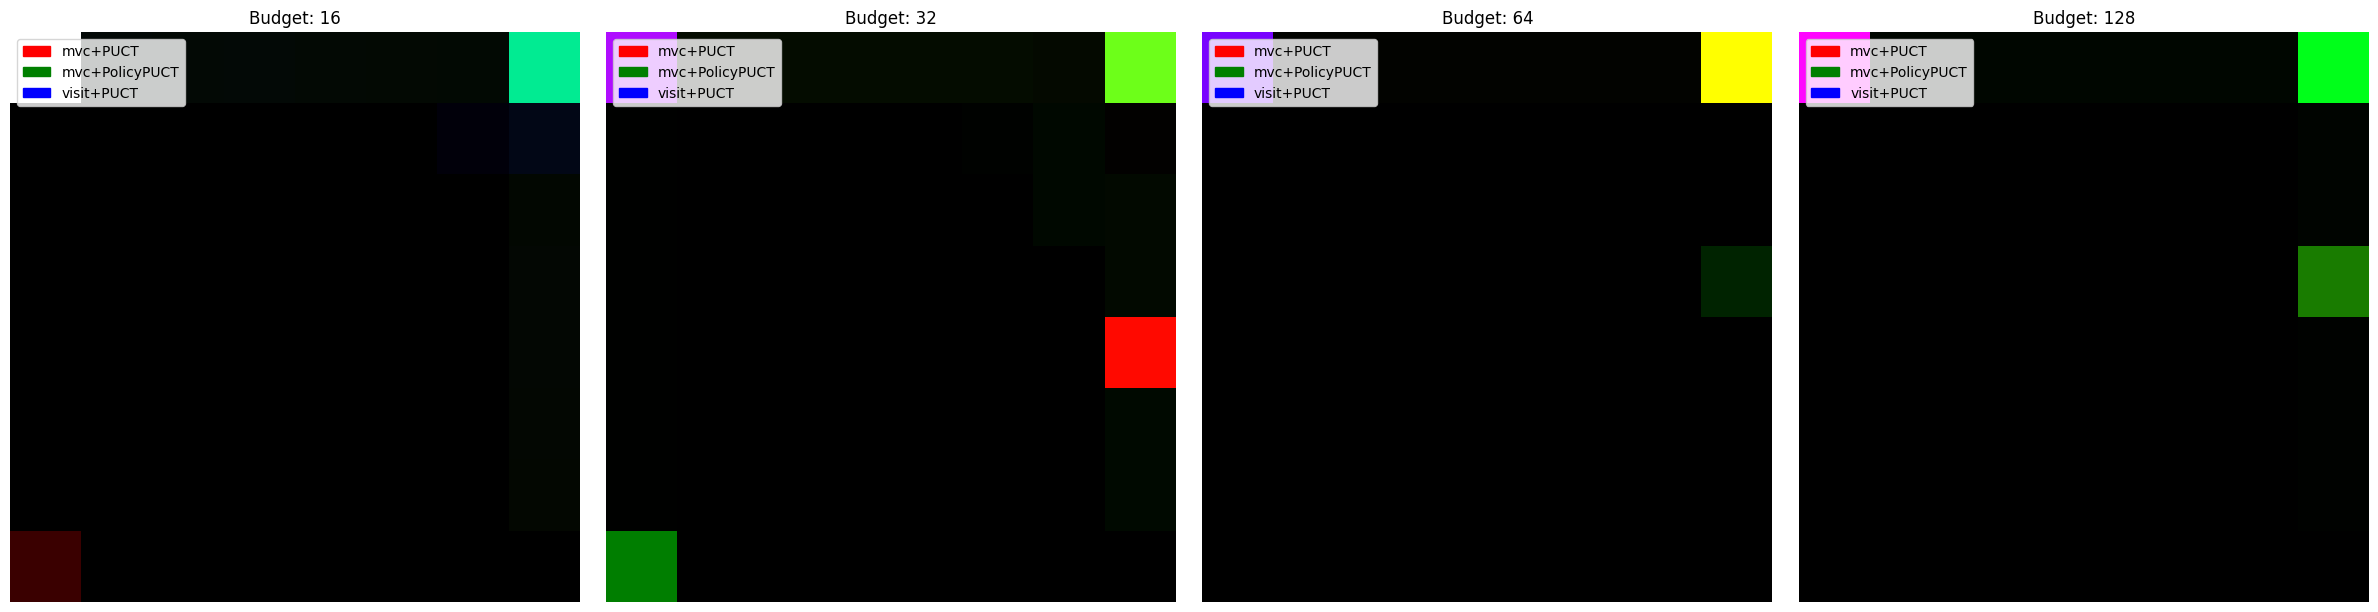

In [8]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['Evaluation/Trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()